# Hyperbolic Equations

A typical hyperbolic equation is the wave equation. A typcical hyperbolic equation might look like this:

$$ c^2 \frac{\partial^2 y}{\partial x^2} = \frac{\partial ^2 y}{\partial t^2} $$

Where $c$ is the speed at which disturbances in $y$ propagate. Note the units! Suppose $y$ has units of distance, and $t$ has units of time. Since $c$ is a *speed*, it would have units of distance/time. Now the partial derivative on the left hand side (LHS) has units of recirpocal distance. The partial dirivative on the right has units of distance over time squared. Multiplying the LHS by $c^2$ sorts out the units so they're consistent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## String Waves

A simple example is a wave on a string. In this case a string is tied between two points. Suppose we give it an initial "pluck" so it has a shape something like this:

(-0.15, 0.15)

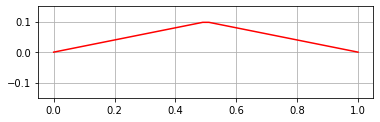

In [2]:
L = 1  # length of string
N = 50 # number of chunks
c = 1.0 # speed
A = 0.1 # amplitude of "pluck"

x = np.linspace(0,L,N)

dx = x[1] - x[0] # what is dx?
y = np.where(x<L/2, x*2*A/L, (L-x)*2*A/L)

fig1, ax1 = plt.subplots()
ax1.plot(x,y,'r-')
ax1.grid()
ax1.set_aspect('equal')
plt.ylim(-.15,0.15)


The goal of this project is to simulate the time evolution of the plucked string.